<a href="https://colab.research.google.com/github/MHoseinHoushmand/Smile_detection/blob/main/Smile_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "drive/MyDrive/images2"
train_dir = os.path.join(PATH, 'train')
print (train_dir)
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')
batch_size = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=IMG_SIZE)


drive/MyDrive/images2/train
Found 2801 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                           shuffle=True,
                                                           batch_size=batch_size,
                                                           image_size=IMG_SIZE)


Found 399 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=batch_size,
                                                           image_size=IMG_SIZE)

Found 800 files belonging to 2 classes.


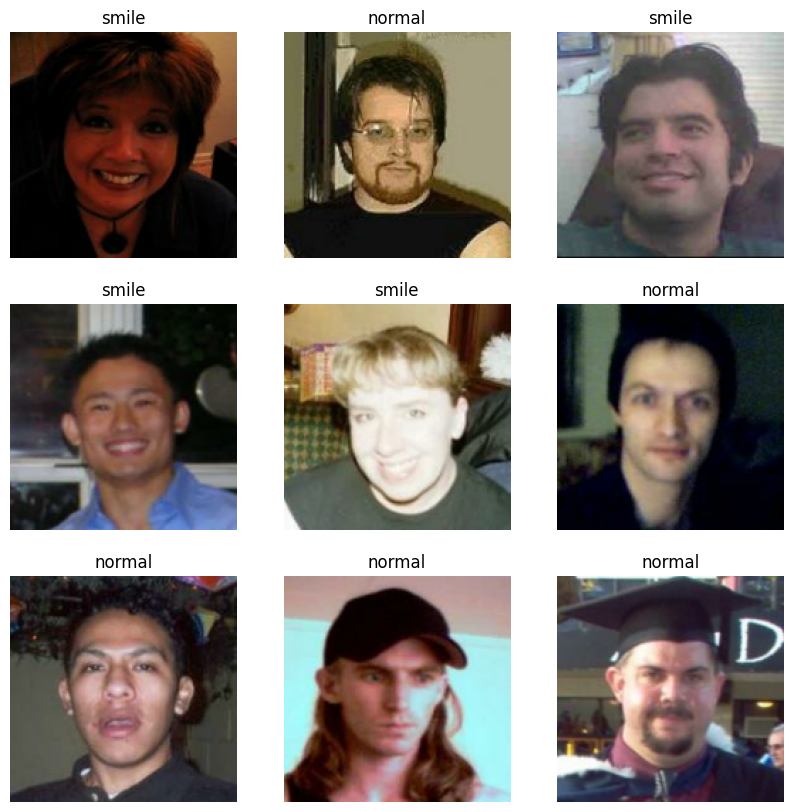

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
])


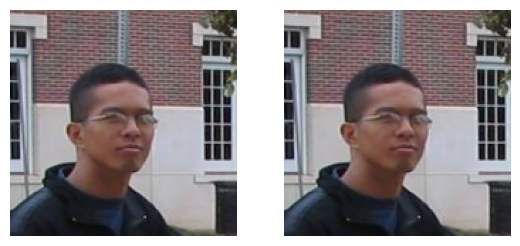

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
88/88 [==============================] - 238s 3s/step - loss: 0.7966 - accuracy: 0.4680 - val_loss: 0.7382 - val_accuracy: 0.4812
Epoch 2/10
88/88 [==============================] - 6s 60ms/step - loss: 0.7508 - accuracy: 0.5102 - val_loss: 0.7060 - val_accuracy: 0.5338
Epoch 3/10
88/88 [==============================] - 5s 58ms/step - loss: 0.7189 - accuracy: 0.5448 - val_loss: 0.6862 - val_accuracy: 0.5714
Epoch 4/10
88/88 [==============================] - 5s 56ms/step - loss: 0.7067 - accuracy: 0.5616 - val_loss: 0.6697 - val_accuracy: 0.5865
Epoch 5/10
88/88 [==============================] - 6s 65ms/step - loss: 0.6883 - accuracy: 0.5844 - val_loss: 0.6568 - val_accuracy: 0.6065
Epoch 6/10
88/88 [==============================] - 8s 79ms/step - loss: 0.6653 - accuracy: 0.5876 - val_loss: 0.6464 - val_accuracy: 0.6065
Epoch 7/10
88/88 [==============================] - 6s 64ms/step - loss: 0.6553 - accuracy: 0.6162 - val_loss: 0.6375 - val_accuracy: 0.6190
Epoch 8/10
88

In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


13/13 [==============================] - 1s 32ms/step - loss: 0.6183 - accuracy: 0.6291


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.62
initial accuracy: 0.63


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
88/88 [==============================] - 5s 57ms/step - loss: 0.6254 - accuracy: 0.6369 - val_loss: 0.6136 - val_accuracy: 0.6366
Epoch 2/10
88/88 [==============================] - 6s 65ms/step - loss: 0.6100 - accuracy: 0.6530 - val_loss: 0.6094 - val_accuracy: 0.6341
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.6079 - accuracy: 0.6541 - val_loss: 0.6051 - val_accuracy: 0.6366
Epoch 4/10
88/88 [==============================] - 6s 70ms/step - loss: 0.6062 - accuracy: 0.6541 - val_loss: 0.6007 - val_accuracy: 0.6416
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.6074 - accuracy: 0.6433 - val_loss: 0.5971 - val_accuracy: 0.6491
Epoch 6/10
88/88 [==============================] - 7s 73ms/step - loss: 0.5899 - accuracy: 0.6701 - val_loss: 0.5942 - val_accuracy: 0.6516
Epoch 7/10
88/88 [==============================] - 5s 58ms/step - loss: 0.5808 - accuracy: 0.6790 - val_loss: 0.5913 - val_accuracy: 0.6591
Epoch 8/10
88

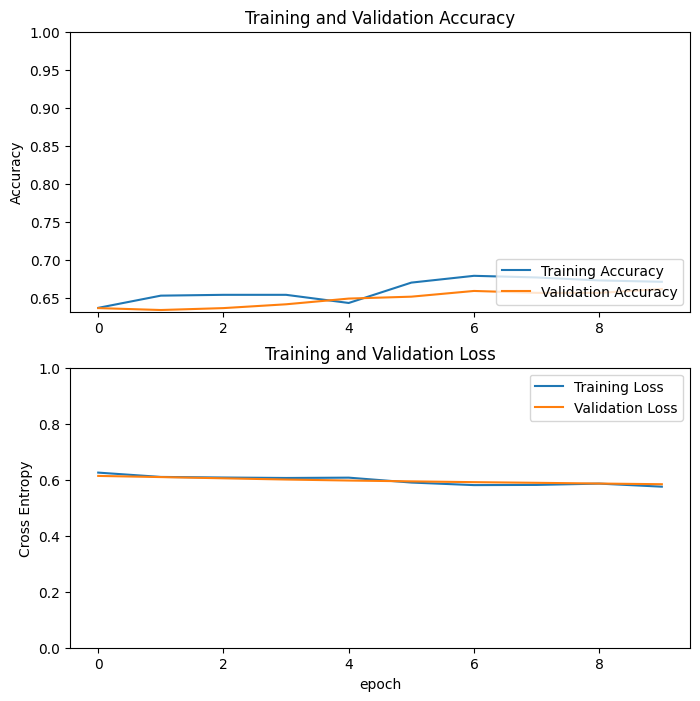

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False



Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])



In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)


56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
88/88 [==============================] - 19s 74ms/step - loss: 0.5596 - accuracy: 0.6851 - val_loss: 0.5762 - val_accuracy: 0.6566
Epoch 11/20
88/88 [==============================] - 7s 79ms/step - loss: 0.4885 - accuracy: 0.7494 - val_loss: 0.5979 - val_accuracy: 0.6491
Epoch 12/20
88/88 [==============================] - 7s 73ms/step - loss: 0.4131 - accuracy: 0.8079 - val_loss: 0.4763 - val_accuracy: 0.7669
Epoch 13/20
88/88 [==============================] - 6s 64ms/step - loss: 0.3755 - accuracy: 0.8154 - val_loss: 0.4614 - val_accuracy: 0.7744
Epoch 14/20
88/88 [==============================] - 7s 77ms/step - loss: 0.3286 - accuracy: 0.8511 - val_loss: 0.5054 - val_accuracy: 0.7794
Epoch 15/20
88/88 [==============================] - 6s 63ms/step - loss: 0.2917 - accuracy: 0.8697 - val_loss: 0.5013 - val_accuracy: 0.7569
Epoch 16/20
88/88 [==============================] - 7s 77ms/step - loss: 0.2615 - accuracy: 0.8790 - val_loss: 0.4317 - val_accuracy: 0.8020
Epoch

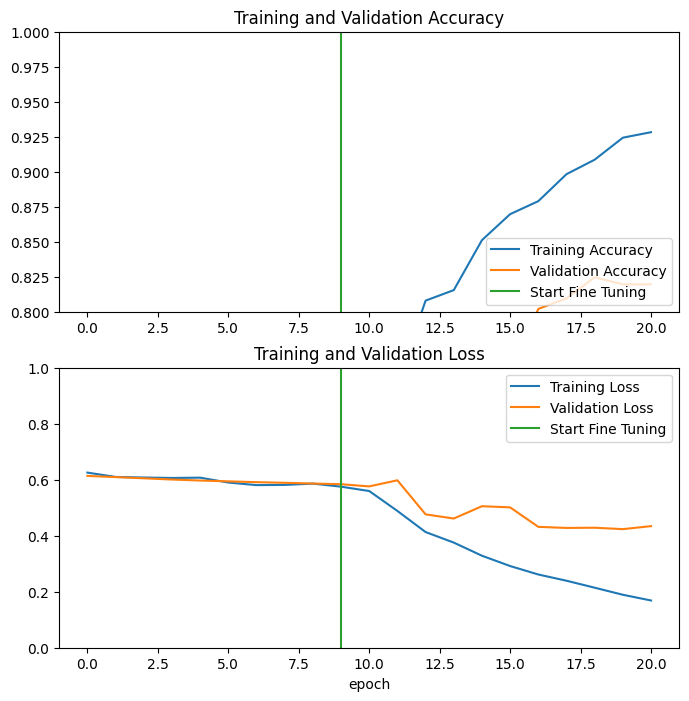

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<class 'numpy.ndarray'>
Predictions:
 [1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1]
Labels:
 [1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1]


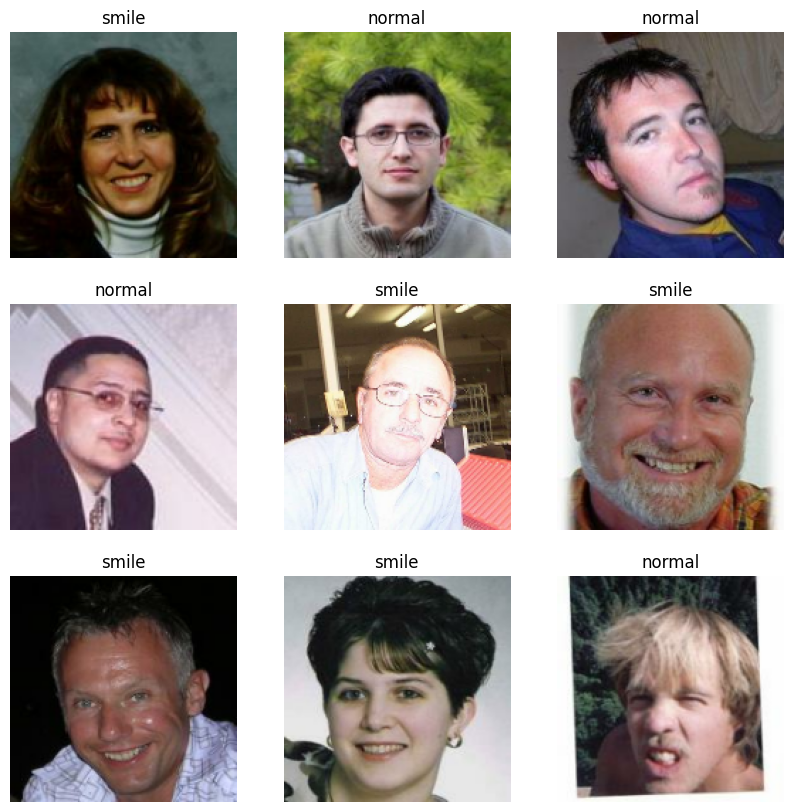

In [ ]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
print(type(image_batch))
predictions = model.predict_on_batch(image_batch).flatten()


# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


25/25 [==============================] - 67s 3s/step - loss: 0.3688 - accuracy: 0.8438
Test accuracy : 0.84375


In [ ]:
model.save("drive/MyDrive/model.hdf5")